# MDL test data

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [6]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from sklearn.metrics import mean_squared_error
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect
from phd.visualization.plot_prediction import plot_total_force, plot_force_components
from scipy.optimize import least_squares
from vessel_manoeuvring_models.prime_system import PrimeSystem, df_prime
import statsmodels.api as sm
import zigzag
import logging
log = logging.getLogger(__name__)
import matplotlib.pyplot as plt
import paper

In [3]:
ship='wPCC'
model_loaders = catalog.load(f"{ship}.models")
time_series = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
time_series_meta_data = catalog.load(f"{ ship }.time_series_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])

shipdata = catalog.load(f"{ship}.ship_data")
shipdata_7m = catalog.load(f"7m.ship_data")


[10/20/23 14:01:41] INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=797953;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=529975;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=528001;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=616284;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=654163;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=114412;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=773618;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=135167;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=1195;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=325994;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [9]:
model = model_loaders['model_with_propeller_race']()

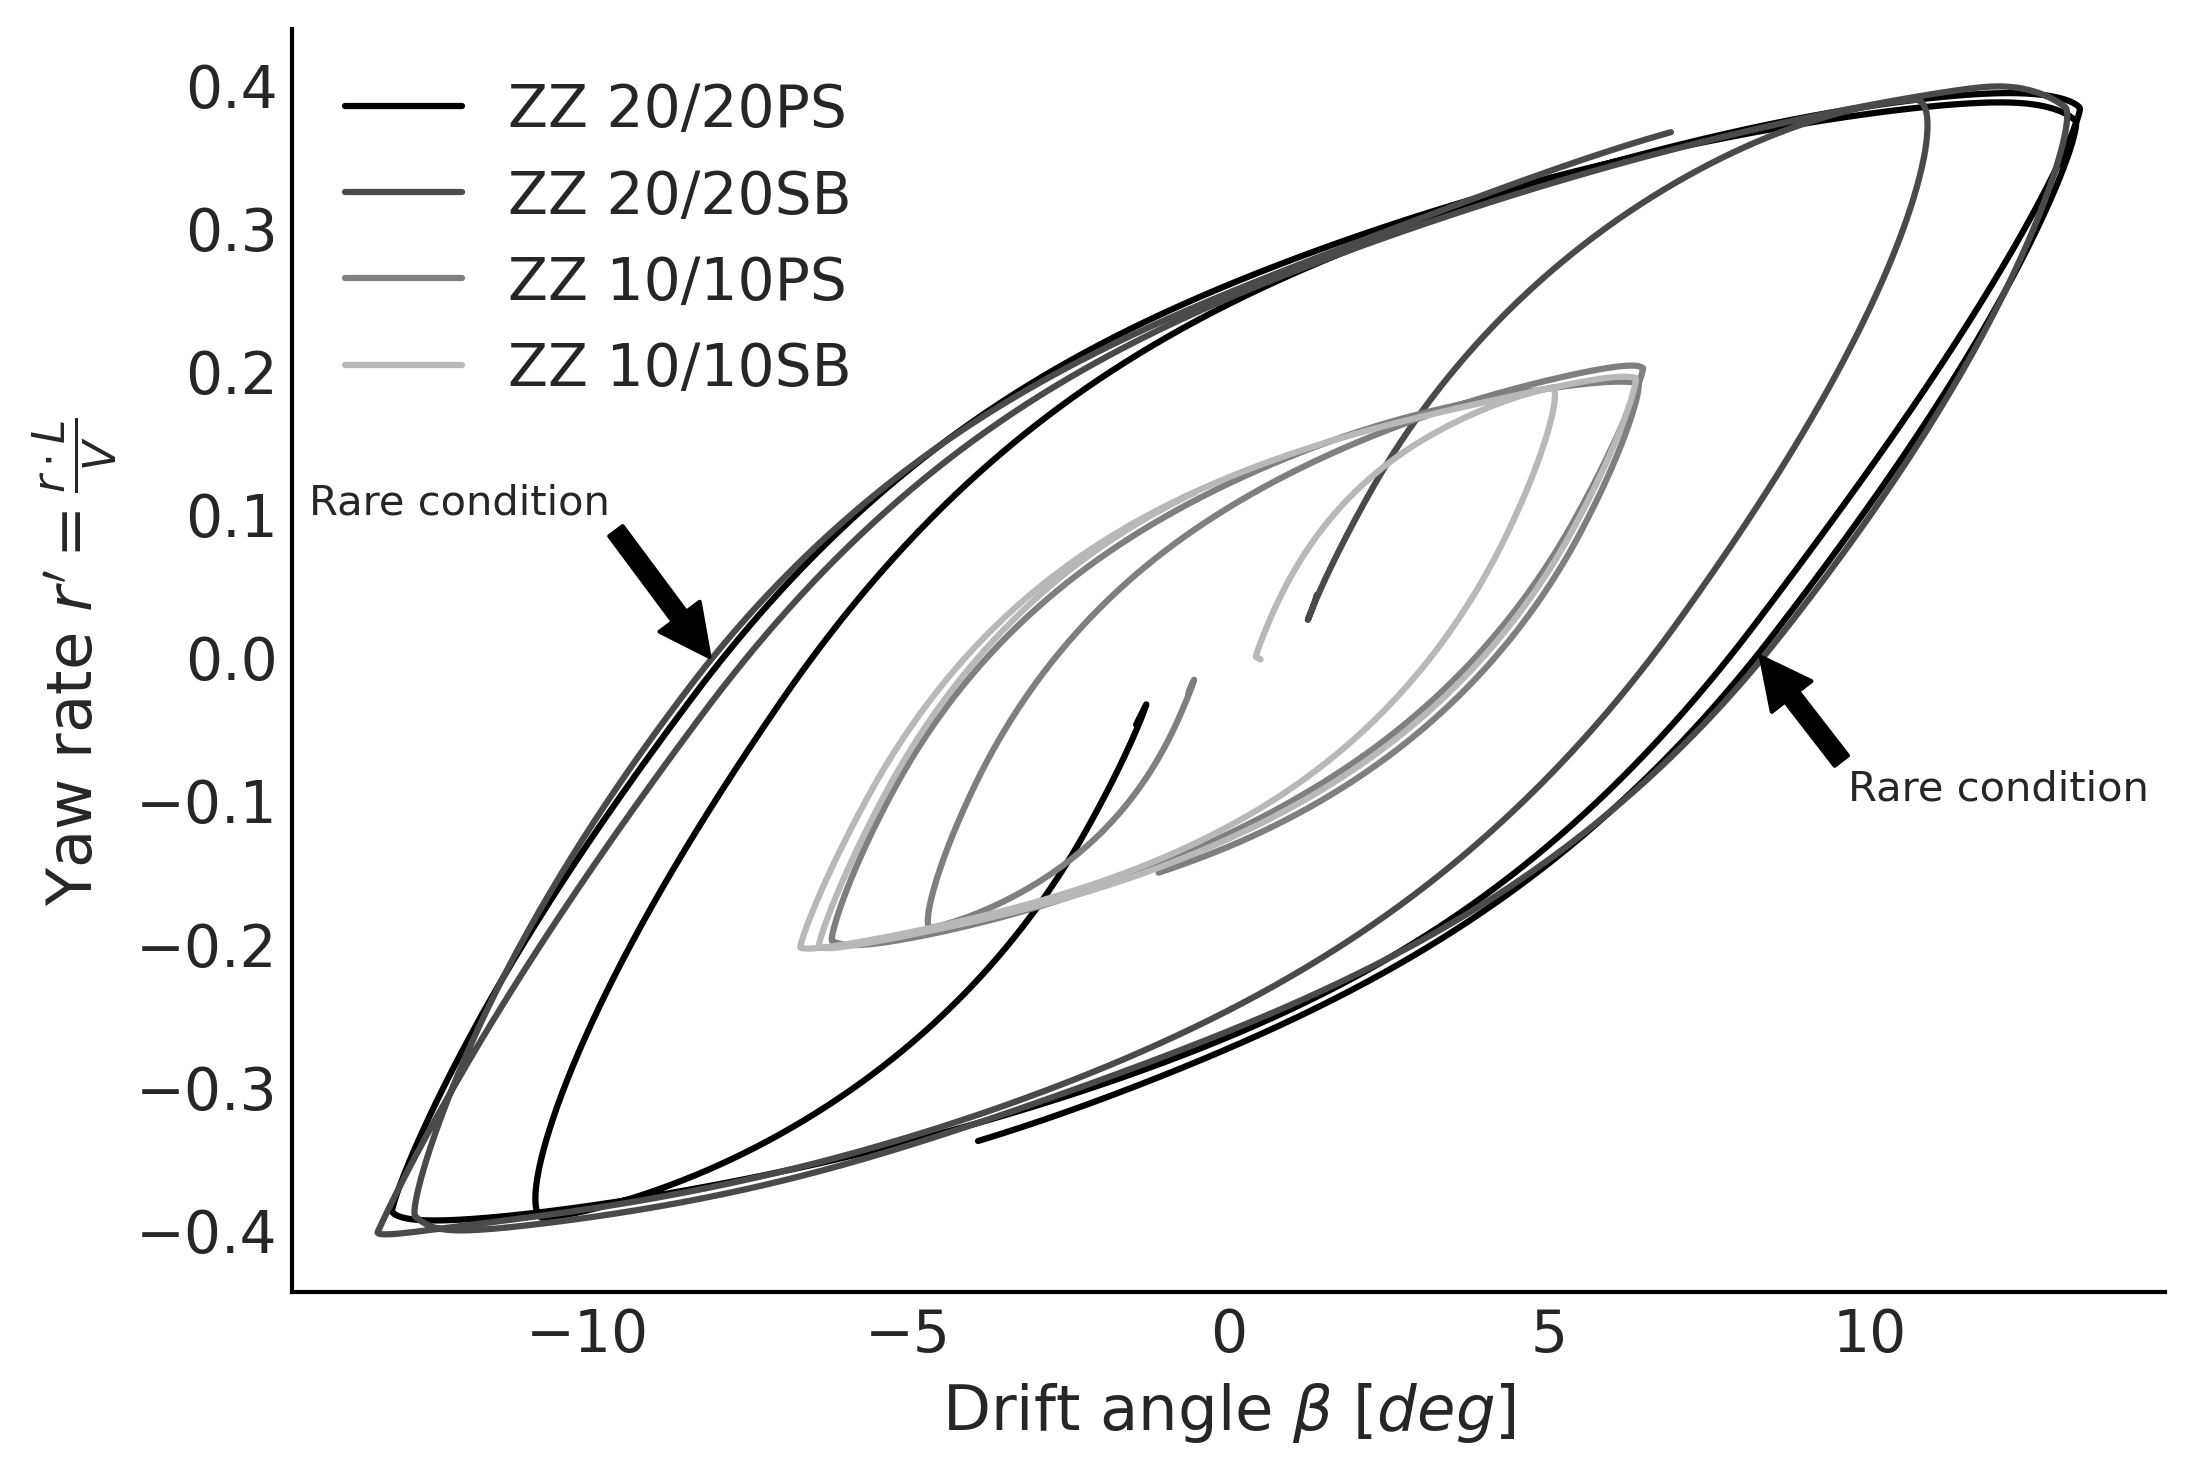

In [42]:
ids = [
22773,
22772,
22770,
22764,
]

fig,ax=plt.subplots()
for id in ids:
    data_MDL2 = time_series[f'wpcc.updated.{id}.ek_smooth']()
    data_MDL2['beta'] = np.arctan2(-data_MDL2['v'],data_MDL2['u'])
    
    data_MDL2['V'] = np.sqrt(data_MDL2['u']**2 + data_MDL2['v']**2)    
    
    data_MDL2_prime = model.prime_system.prime(data_MDL2[['beta','r']], U=data_MDL2['V'])
    data_MDL2_prime['beta_deg'] = np.rad2deg(data_MDL2_prime['beta'])
    
    meta_data = time_series_meta_data.loc[id]
    data_MDL2_prime.plot(x='beta_deg', y='r', label=f"{meta_data['comment']}", ax=ax)

    
ax.set_xlabel(r"Drift angle $\beta$ $[deg]$")
ax.set_ylabel(r"Yaw rate $r'=\frac{r \cdot L}{V}$")
#ax.set_ylim(-0.4,0.4)
#ax.set_xlim(-15,15)


ax.annotate("Rare condition", xy=(-8.1, 0), xytext=(-12,0.1), horizontalalignment='center', arrowprops={'shrink':0.0})
ax.annotate("Rare condition", xy=(8.3, 0), xytext=(12,-0.1), horizontalalignment='center', arrowprops={'shrink':0.0})

ax.grid(False)

paper.save_fig(fig=fig, file_name="phase_portrait.svg")